In [1]:
import os
import sys
sys.path.insert(0, '/home/guijiyang/Code/python/torch/metallic_Surface_detect.pytorch')
# os.chdir('/home/guijiyang/Code/python/torch/metallic_Surface_detect.pytorch')

from unetplus import Unet_plus
from utils import rle2mask, displayTopMasks, computeDice
from ImgDataset import ImageDataset
from transform import ImageTransform
from config import detectConfig
from detect import postMask
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
data_dir = '/home/guijiyang/dataset/severstal_steel'

In [2]:
class_df=pd.read_csv('csv/class_IoU_.csv')

class_IoU=class_df[class_df['class_IoU']<0.1]
class_IoU.head()

,ImageId_ClassId,class_IoU
1,00031f466.jpg,1.136364e-09
3,000789191.jpg,1.186634e-11
8,001982b08.jpg,8.445946e-10
9,001d1b355.jpg,7.259001e-11
10,001d3d093.jpg,7.242178e-11


In [5]:
cfg = detectConfig()
cfg.image_size = (1600, 256)
cfg.mean = 0.344
cfg.std = 0.14
cfg.min_size=1000
cfg.display()
train_data = ImageDataset(data_dir, transform=ImageTransform(
    cfg.image_size, cfg.mean, cfg.std))



device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

WEIGHT_PATH = 'weights'
MODEL_NAME = os.path.join(WEIGHT_PATH, 'unet_plus_99.pth')

# 加载模型
model = Unet_plus(1, 4).to(device)

if os.path.exists(MODEL_NAME):
    model.load_state_dict(torch.load(MODEL_NAME))
else:
    raise Exception('cannot find model weights')

model.eval()


Configurations:
adjust_iter                    10
alpha                          0.8
batch_size                     2
gamma                          0.0
image_size                     (1600, 256)
learning_rate                  0.0001
lr_decay                       0.8
max_epochs                     30
mean                           0.344
min_size                       1000
std                            0.14
threshold                      0.5




Unet_plus(
  (inconv): inconv(
    (conv): double_conv_in(
      (conv): Sequential(
        (0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
        (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
          (3

1
0


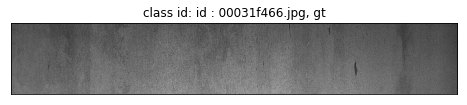

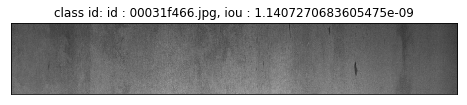

3
22


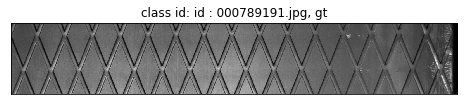

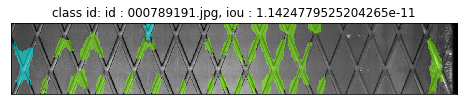

8
0


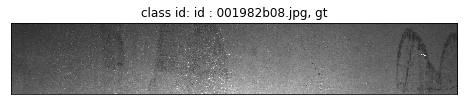

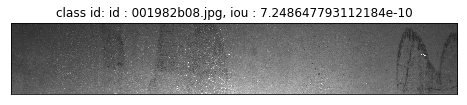

9
5


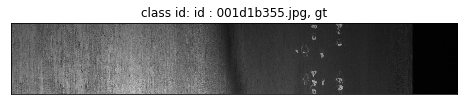

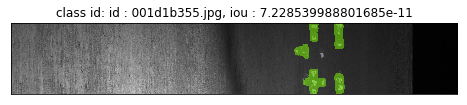

10
2


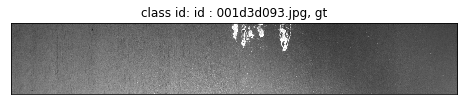

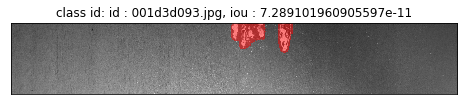

13
1


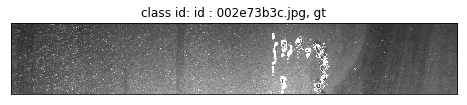

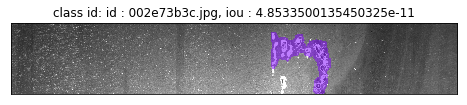

In [6]:
with torch.no_grad():
    count = 0
    for idx in class_IoU.index:
        if count > 5:
            break
        print(idx)
        image_id, image, masks = train_data[idx]
        image = image.reshape(1, *image.shape)
        masks = masks.reshape(1, *masks.shape)
        output = model(image.to(device))
        
        dice_iou = computeDice(output, masks.to(device), reduction='sum')
        
        orignal_image = cv2.imread(os.path.join(data_dir, 'train_images', image_id))
        gt_masks = masks.cpu().clone().numpy()
        gt_masks = np.transpose(gt_masks, axes=[1, 2, 3, 0])
        gt_masks = np.repeat(gt_masks, 3, axis=-1)
        pred_mask = output.cpu().clone().numpy()
        pred_mask,num=postMask(pred_mask, cfg.threshold, cfg.min_size)
        print(num)
        pred_mask = np.transpose(pred_mask, axes=[1, 2, 3, 0])
        pred_mask = np.repeat(pred_mask, 3, axis=-1)
        displayTopMasks(orignal_image, gt_masks,
                        'id : {}, gt'.format(image_id))
        displayTopMasks(orignal_image, pred_mask,
                        'id : {}, iou : {}'.format(image_id, dice_iou))

        # break
        count += 1